### Steve's simple lag 

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import random
import math
from typing import Tuple, List

import numpy as np
import torch
from torch.optim import AdamW
import pandas as pd
from icecream import ic

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.callbacks import TFMProgressBar
from darts.metrics import mape, smape
from darts.models import BlockRNNModel

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

# for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
seed_everything(seed)

Seed set to 42


42

The following imports and setttings  
  
import logging  
import warnings  
logging.disable(logging.CRITICAL)  
warnings.filterwarnings("ignore")  
  
will disable this output:  
```
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | fc              | Sequential       | 130    | train
-------------------------------------------------------------

2.9 K     Trainable params  
0         Non-trainable params  
2.9 K     Total params  
0.012     Total estimated model params size (MB)  
8         Modules in train mode  
0         Modules in eval mode  
/usr/local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch
```

In [2]:
import logging
import warnings
logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

Create funtions for making p and q

In [3]:
def create_scaled_random_array(n_points: int) -> np.ndarray:
    """
    Creates a scaled random ndarray of shape (n_points, 1).

    Parameters:
    n_points (int): The number of points in the array.

    Returns:
    numpy.ndarray: A scaled random ndarray with the first index set to 0.0.
    """
    random_values = np.random.uniform(-1, 1, n_points).astype(np.float32)
    random_values[0] = 0.0
    return random_values


def create_simple_lagged_array(input_array: np.ndarray, lag: int) -> np.ndarray:
    """
    Creates a lagged version of the input array.  The lag is a positive or negative integer.

    Parameters:
    input_array (numpy.ndarray): The input array.
    lag (int): The lag to apply.

    Returns:
    numpy.ndarray: The lagged array.
    """
    q = np.zeros_like(input_array).astype(np.float32)
    n_points = len(input_array)
    for i in range(n_points - 1):
        if i + lag < 0:
            q[i] = input_array[0]
        elif i + lag >= n_points - 1:
            q[i] = input_array[i - 1]
        else:
            q[i] = input_array[i + lag]
    return q


def plot_p_q(p: np.ndarray, q: np.ndarray, title: str = "") -> None:
    """
    Plots two time series.

    Parameters:
    p (numpy.ndarray): The first time series.
    q (numpy.ndarray): The second time series.
    title (str): The title of the plot (default is an empty string).

    Returns:
    None
    """
    plt.plot(p, label="p")
    plt.plot(q, label="q")
    plt.title(title)
    plt.legend()
    plt.show()

plot p and q with lags of -1 and 1

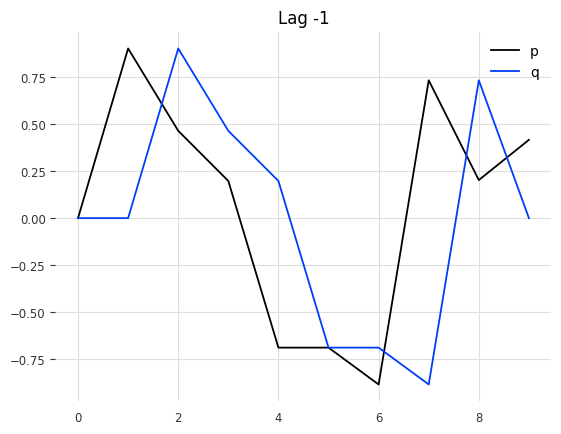

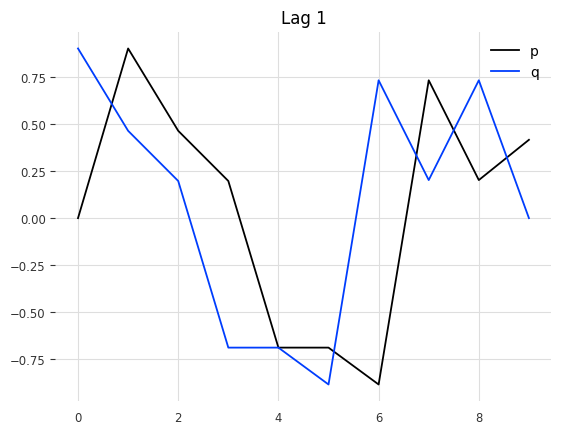

In [4]:
p = create_scaled_random_array(n_points=10)

q = create_simple_lagged_array(input_array=p, lag=-1)
plot_p_q(p, q, title="Lag -1")

q = create_simple_lagged_array(input_array=p, lag=1)
plot_p_q(p, q, title="Lag 1")

Function to make a multi-series of p and q pairs  
Function to plot a multi-series of p and q pairs  

In [5]:
def create_mult_p_q_series(n_series: int, n_points: int, lag: int) -> List[TimeSeries]:
    """
    Creates multiple pairs of target (p) and lagged (q) time series as Darts TimeSeries objects.

    Parameters:
    n_series (int): The number of time series pairs to create.
    n_points (int): The number of points in each time series.
    lag (int): The lag to apply to each time series.

    Returns:
    List[TimeSeries]: A list of Darts TimeSeries objects, each containing a pair of target and lagged time series.
    """
    p_q_series = []

    for i in range(n_series):
        p = create_scaled_random_array(n_points=n_points)
        q = create_simple_lagged_array(input_array=p, lag=lag)
        p_q = TimeSeries.from_values(p).stack(TimeSeries.from_values(q))
        p_q = p_q.with_columns_renamed(col_names=["0", "0_1"], col_names_new=["p", "q"])
        p_q_series.append(p_q)
    return p_q_series

def plot_p_q_series(p_q_series: List[TimeSeries], n_columns: int = 2) -> None:
    """
    Plots multiple time series.

    Parameters:
    p_q_series (List[TimeSeries]): The list of time series to plot.
    title (str): The title of the plot (default is an empty string).

    Returns:
    None
    """
    n_rows = math.ceil(len(p_q_series) / n_columns)

    fig_size_height = math.ceil(60 / n_columns)
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, fig_size_height))

    for i in range(len(p_q_series)):
        ax = axes[i // n_columns, i % n_columns]
        p_q_series[i].plot(ax=ax)
        ax.set_title(f"p_q series {i}")
        ax.set_xlabel("")
        ax.legend()

    plt.tight_layout()
    plt.show()

Create and plot a p_q_series

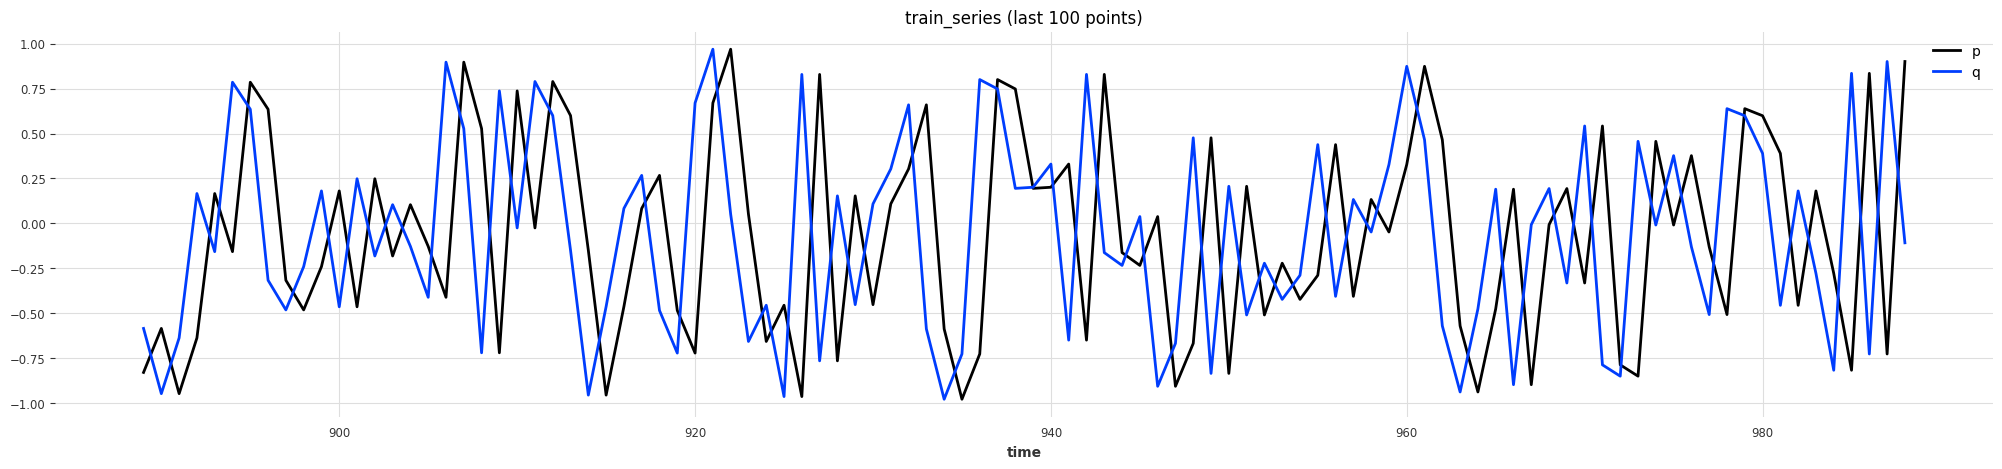

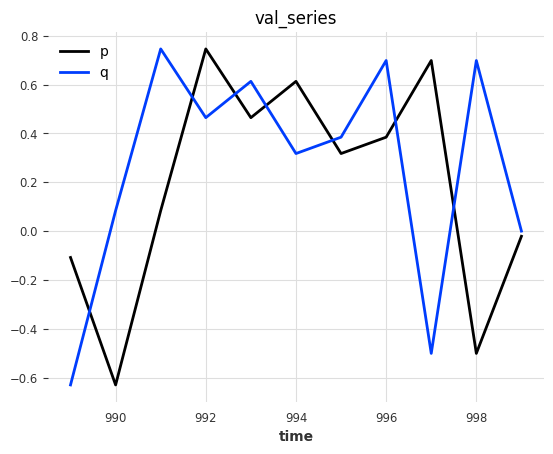

ic| len(train_series): 989, len(val_series): 11


In [6]:
N_MULTI_SERIES = 1
SERIES_LEN = 1000
LAG = 1
INPUT_CHUNK_LEN = 10
OUTPUT_CHUNK_LEN = 1

# Create multiple p_q series
p_q_series = create_mult_p_q_series(n_series=N_MULTI_SERIES, n_points=SERIES_LEN, lag=LAG)
# Reduce sequence of series to a single series
p_q_series = p_q_series[0]
val_series_len = INPUT_CHUNK_LEN + OUTPUT_CHUNK_LEN
train_series, val_series = p_q_series[:-val_series_len], p_q_series[-val_series_len:]

# Plot multiple p_q series
# plot_p_q_series(p_q_series, n_columns=1)
plt.figure(figsize=(25, 5))
train_series[-100:].plot()
plt.title("train_series (last 100 points)")
plt.show()

val_series.plot()
plt.title("val_series")
plt.show()

_ = ic(len(train_series), len(val_series))

In [7]:
LOG_DIR = r"/workspaces/darts/examples/darts_logs/ts_generation"

def create_BlockRNNModel(n_epochs, sub_dir="default"):
    tensorboard_logger = TensorBoardLogger(save_dir=LOG_DIR, name=sub_dir)
    pl_trainer_kwargs = {
        "accelerator": "cpu",
        "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        "logger": tensorboard_logger,
    }

    optimizer_kwargs = {"lr": 1e-3}
    return BlockRNNModel(
        model="LSTM",
        input_chunk_length=INPUT_CHUNK_LEN,
        output_chunk_length=OUTPUT_CHUNK_LEN,
        n_epochs=n_epochs,
        batch_size=32,
        optimizer_kwargs=optimizer_kwargs,
        random_state=seed,
        log_tensorboard=True,
        model_name="block_rnn_model",
        pl_trainer_kwargs=pl_trainer_kwargs,
    )

In [ ]:
# %mkdir ./darts_logs/ts_generation/model_save_1200
# model.save("./darts_logs/ts_generation/model_save_650/model.pt")

In [73]:
# model = create_BlockRNNModel(n_epochs=1200)
model.fit(series=train_series, val_series=val_series)
model.save("./darts_logs/ts_generation/model_save_1200/model.pt")
# loaded_model = model.load("./darts_logs/ts_generation/model_save1/model.pt")

Training: 0it [00:00, ?it/s]

800 epochs

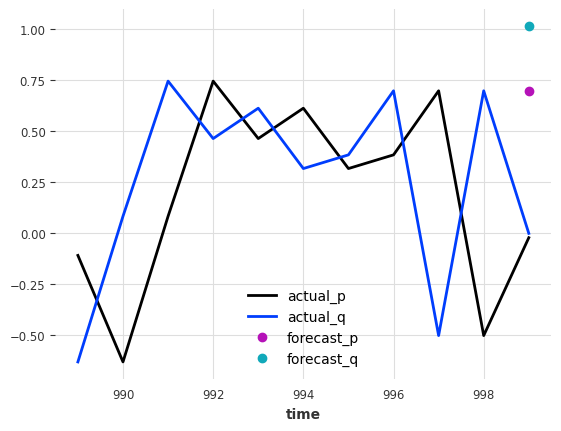

In [74]:
pred = model.predict(n=1, series=val_series[:INPUT_CHUNK_LEN])
val_series.plot(label="actual")
pred.plot(label="forecast")
plt.legend()

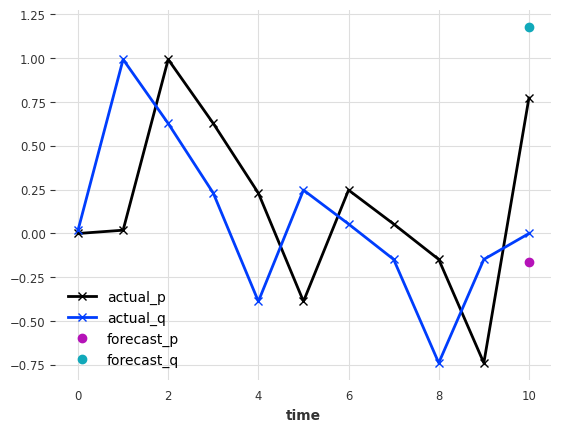

In [101]:
# Create multiple p_q series
new_val_series = create_mult_p_q_series(n_series=1, n_points=val_series_len, lag=LAG)
# Reduce sequence of series to a single series
new_val_series = new_val_series[0]
pred = model.predict(n=1, series=new_val_series[:INPUT_CHUNK_LEN])
new_val_series.plot(label="actual", marker='x')
pred.plot(label="forecast")
plt.legend()
plt.show()